In [1]:
#######################################################
# Goal of this code is to generate 1st and 2nd vertical structures for Q
# 2023.7.13, 2024.4.5: Modified
# Mu-Ting Chien
#########################
import numpy as np
from numpy import dtype
from netCDF4 import Dataset
import sys
sys.path.append('/home/disk/eos4/muting/function/python/')
import mjo_mean_state_diagnostics as MJO
import KW_diagnostics as KW
import os
import matplotlib.pyplot as plt

In [2]:
DIR         = '/home/disk/eos4/muting/'
dir_out     = DIR+'KW/'
dir_in1     = dir_out+'output_data/RA_EAPEG_EKEG/3hr/'
dir_in2     = dir_in1+'final/'
dir_in_test = dir_in1+'test_EOF/'
fig_dir     = dir_out+'figure/RA_EAPEG_EKEG/post_general_exam/'
os.makedirs(dir_in_test, exist_ok=True)

In [3]:
# Load EOF from 05.calculate_eof.ipynb for comparison
output = dir_in2+'EOF_QWU.npz' 
data = np.load(output)
EOFQ1_ref = data['EOFQ1']
EOFQ2_ref = data['EOFQ2'] 
EOFW1_ref = data['EOFW1'] 
EOFW2_ref = data['EOFW2'] 
EOFU1_ref = data['EOFU1'] 
EOFU2_ref = data['EOFU2']
plev_ref  = data['plev']

In [4]:
###############################
# Step1: Load Q_merproj_remove_lowpass
file = dir_in2+'merdional_proj_3d_remove_lowpass.nc' # Updated: 13th July, 2023
data  = Dataset(file,'r',format='NETCDF4')
Q = data.variables['Q_proj'][:] #(time, plev, lon)
T = data.variables['T_proj'][:]
W = data.variables['w_proj'][:]
plev = data.variables['plev'][:]
time = data.variables['time'][:]
lon  = data.variables['lon'][:]
nlev = np.size(plev)
nt   = np.size(time)
nlon = np.size(lon)

In [5]:
# Step2: Check if there are nans in Q
print('# of nans in Q:',np.sum(np.isnan(Q)))
print('# of nans in T:',np.sum(np.isnan(Q)))

# of nans in Q: 0
# of nans in T: 0


In [9]:
print(plev)

[125. 150. 175. 200. 225. 250. 300. 350. 400. 450. 500. 550. 600. 650.
 700. 750. 775. 800. 825. 850. 875. 900. 925. 950. 975.]


finish vertical integration
Theta before adjustment: 0.0
Theta final: 0.0


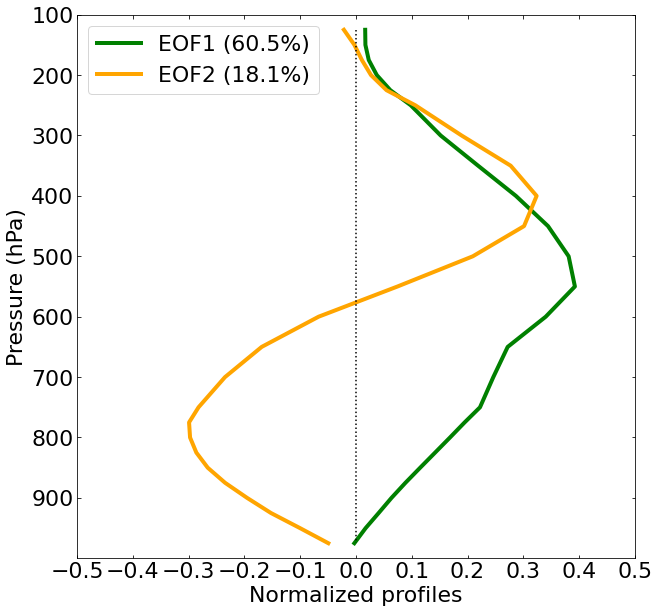

In [14]:
# Step 3: Updated method to calculate EOF (same as Chien and Kim 2024, aquaplanet)
EOF1, EOF2, PC1, PC2 = KW.calculate_plot_eof(Q, plev, 0, fig_dir)

# Rotation of EOF
R_EOF1_raw, R_EOF2_raw, th = KW.rotate_eof(EOF1, EOF2, plev, 0, fig_dir) #0 represents it is not CTL

# Apply 10 passes of 1-2-1 filter for smoothing of EOF
R_EOF1_smooth = KW.smoothing_121(R_EOF1_raw)
R_EOF2_smooth = KW.smoothing_121(R_EOF2_raw)
    
np.savez(dir_in_test+'EOF.npz', R_EOF1_raw=R_EOF1_raw, R_EOF2_raw=R_EOF2_raw,\
    R_EOF1_smooth=R_EOF1_smooth, R_EOF2_smooth=R_EOF2_smooth, plev=plev)        

In [4]:
calc_eof = 0
if calc_eof == 0:
    data          = np.load(dir_in_test+'EOF.npz')
    R_EOF1_raw    = data['R_EOF1_raw']
    R_EOF2_raw    = data['R_EOF2_raw']
    R_EOF1_smooth = data['R_EOF1_smooth']
    R_EOF2_smooth = data['R_EOF2_smooth'] 
    plev          = data['plev'] 

In [5]:
# Step 4:  Load Tm, Zm data
file_in = dir_in2+'merdional_proj_3d_raw.nc'
data    = Dataset(file_in, "r", format="NETCDF4")
#
T_proj  = data.variables['T_proj'][:] #(time, plev, lon)
Tm = np.nanmean(np.nanmean(T_proj,2),0)
del T_proj
#
Z_proj  = data.variables['gph_proj'][:]
Zm = np.nanmean(np.nanmean(Z_proj,2),0) 
del Z_proj

In [6]:
# Step 5: Calculate vertical mode of U

# Calculate Sp
Sp, N2, Hs, plev_N2 = KW.calculate_Sp_N2_Hs(Tm, Zm, plev) 
np.savez(dir_in_test+'Sp_N2_Tm_Zm.npz',Sp=Sp, N2=N2, plev_N2=plev_N2, Tm=Tm, Zm=Zm)

# Find vertical mode of omega and U
EOF1_W, EOF2_W, EOF1_U, EOF2_U = KW.Q_vert_mode_to_WU( R_EOF1_raw[1:-1], R_EOF2_raw[1:-1], Sp )

# Save output
np.savez(dir_in_test+'EOF_WU.npz', EOF1_W=EOF1_W[1:-1], EOF1_U=EOF1_U, EOF2_W=EOF2_W[1:-1], EOF2_U=EOF2_U, plev_eofu = plev[2:-2])

In [8]:
# Assign EOF mode of Q
EOF1_Q = R_EOF1_smooth
EOF2_Q = R_EOF2_smooth

start plot EOF


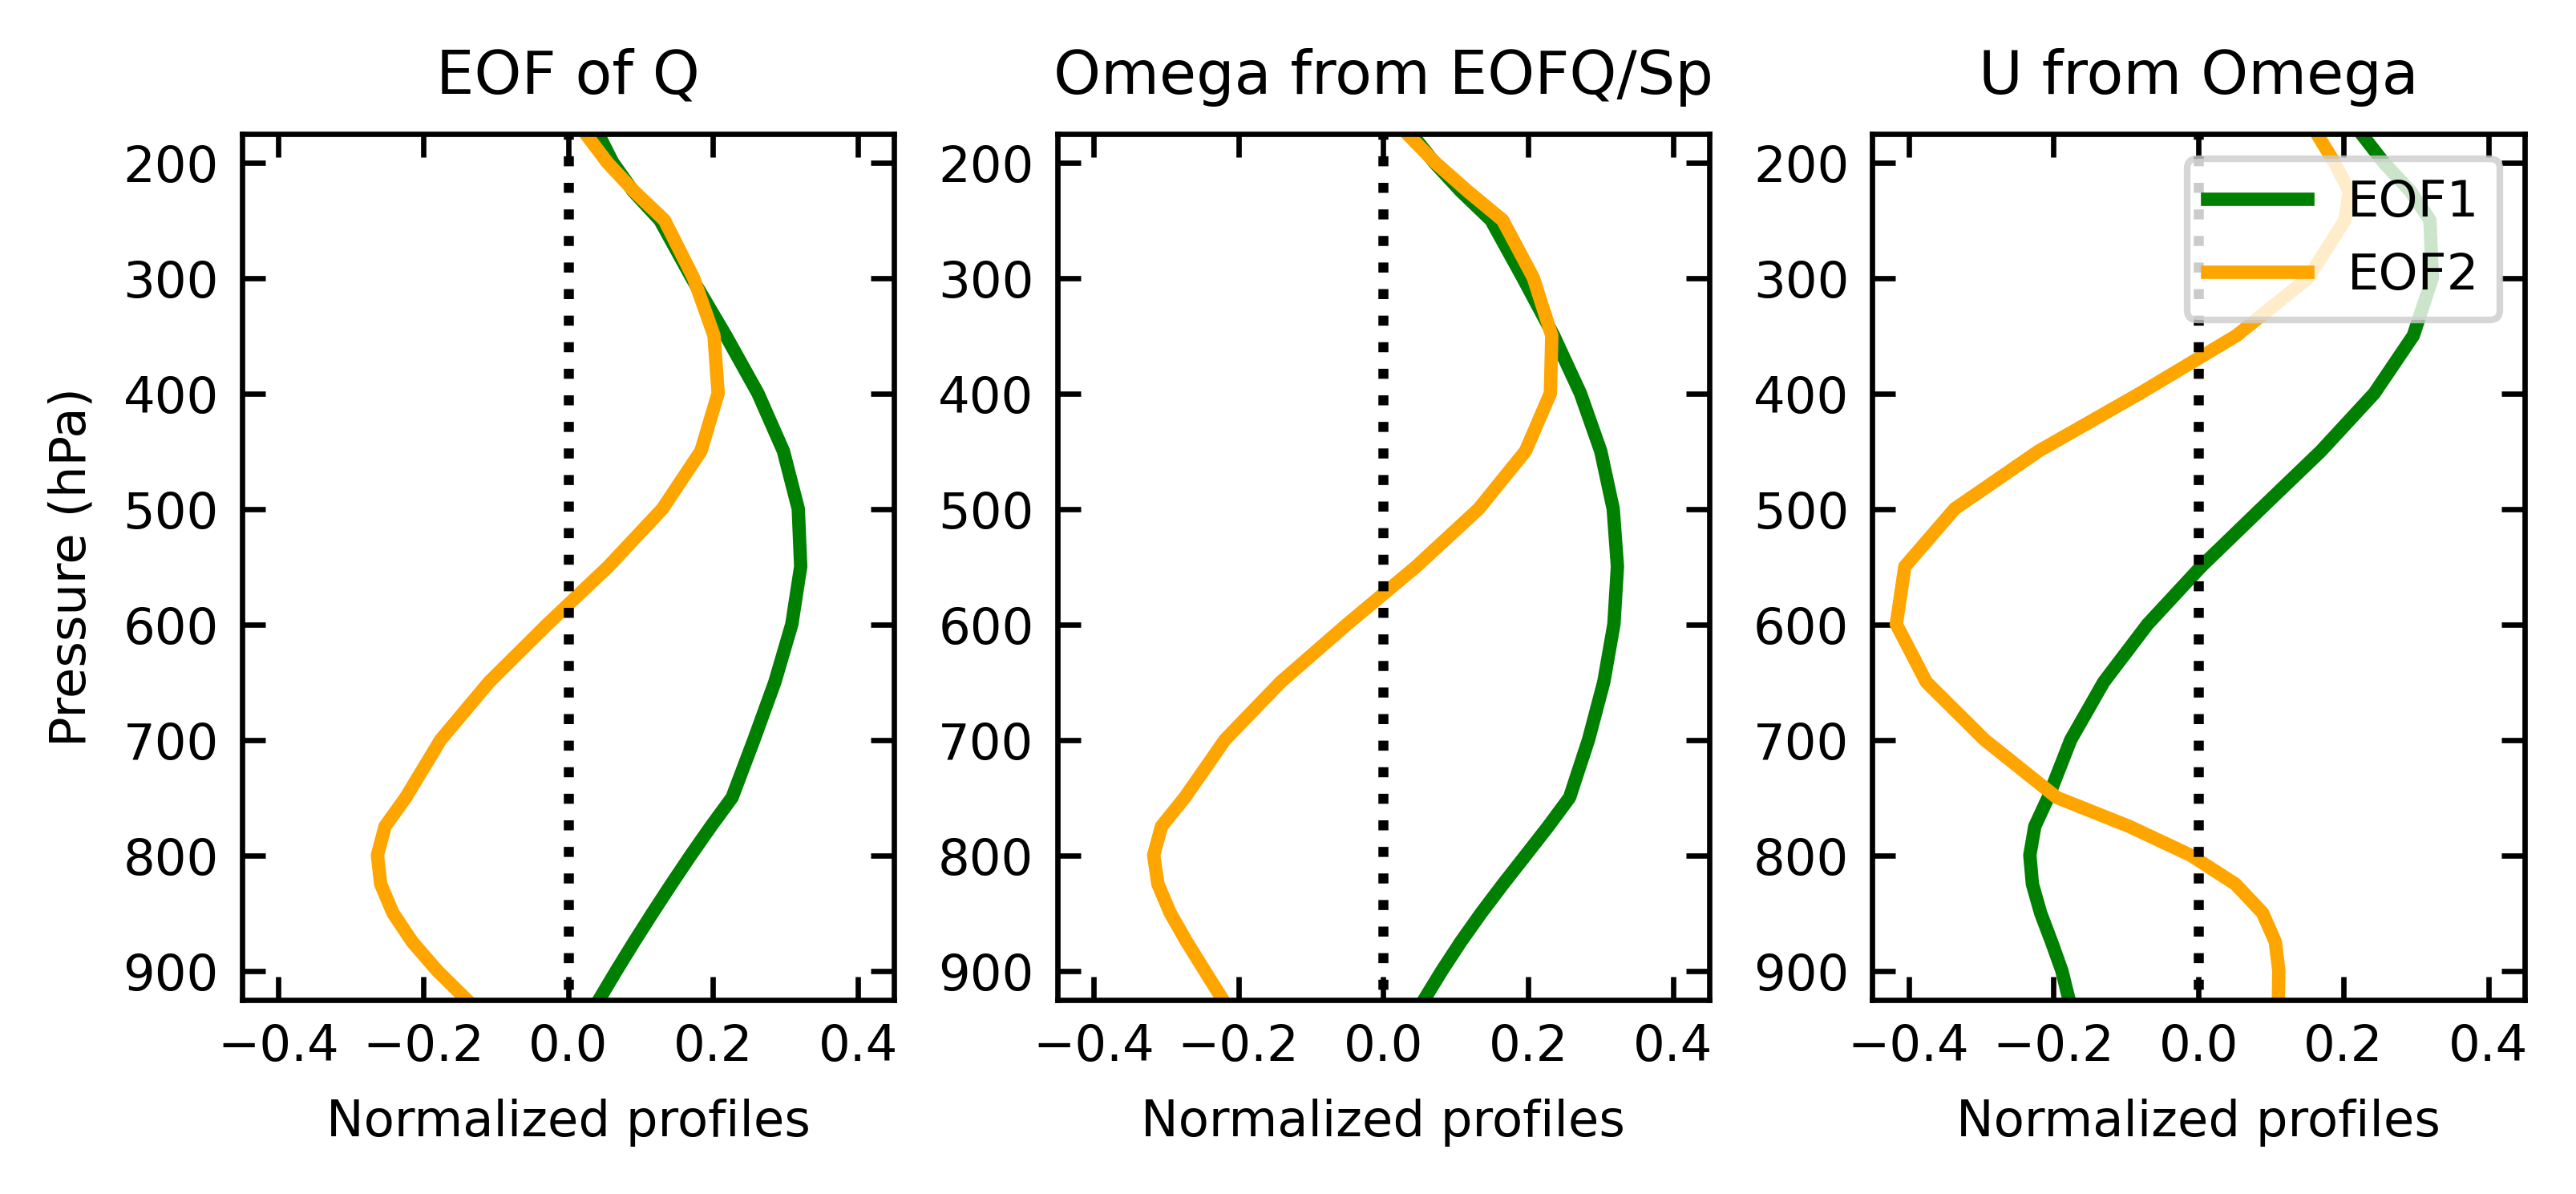

In [14]:
#########
# Fig 1: plot EOF
#########
plot_EOF = 1
if plot_EOF == 1:
    vname = 'Q1ano'
    vv = vname
    print('start plot EOF')
    '''
    expvar1 = "%.1f" %expvar[0]
    expvar2 = "%.1f" %expvar[1]
    expvarW1 = "%.1f" %expvar_W[0]
    expvarW2 = "%.1f" %expvar_W[1]
    '''
    zero = np.zeros([np.size(plev)])

    # plot eof
    fig,axes = plt.subplots(1,3,figsize=(6.5, 2.4),dpi=600)
    plt.subplots_adjust(left=0.25,right=0.98,top=0.9,bottom=0.15,wspace=0.25)
    plt.rcParams.update({'font.size': 7.5})
    for iplt in range(0,3):
        plt.subplot(1,3,iplt+1)
        if iplt == 0:
            plt.plot(EOF1_Q[2:-2],plev[2:-2],'g',EOF2_Q[2:-2],plev[2:-2],'orange',linewidth=2)
            plt.title('EOF of Q')
        elif iplt == 1:
            plt.plot(EOF1_W[1:-1],plev[2:-2],'g',EOF2_W[1:-1],plev[2:-2],'orange',linewidth=2)
            plt.title('Omega from EOFQ/Sp')
        elif iplt == 2:
            plt.plot(EOF1_U,plev[2:-2],'g',EOF2_U,plev[2:-2],'orange',linewidth=2)
            plt.title('U from Omega')            
        plt.plot(zero,plev,'k:')
        ax = plt.gca()
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        ax.tick_params(axis="both", direction="in")
        plt.gca().invert_yaxis()
        plt.xlabel('Normalized profiles')
        if iplt == 0:
            plt.ylabel('Pressure (hPa)')
            #plt.legend(('EOF1','EOF2'),loc='upper left')
        elif iplt == 2:
            plt.legend(('EOF1','EOF2'),loc='upper right')
        #elif iplt == 1:
        #    #plt.legend(('EOF1','EOF2'),loc='upper right')
        plt.axis([-0.45,0.45,np.max(plev[2:-2]),np.min(plev[2:-2])])
        plt.xticks(np.arange(-0.4,0.6,0.2))
        plt.yticks(np.arange(900,100,-100))
    plt.savefig(fig_dir+'eof_QWU_updated.png',dpi=600)
    plt.show()

In [19]:
# Load expvar
file_in = dir_in2+'EOF_QWU.nc' 
data = Dataset(file_in, 'r', format='NETCDF4')
expvar_Q = data.variables['expvar_Q'][:]

In [28]:
############################
# Save EOF as npz file, if the nc file saving does not work
##########################
output = dir_in2+'EOF_QWU_updated.npz' 
np.savez(output, EOF1_Q=EOF1_Q[2:-2], EOF2_Q=EOF2_Q[2:-2], plev=plev[2:-2],\
         EOF1_W=EOF1_W[1:-1], EOF2_W=EOF2_W[1:-1], EOF1_U=EOF1_U, EOF2_U=EOF2_U,\
        expvar_Q=expvar_Q)

In [27]:
###########
# Save EOF using NC file
###########
file_out = dir_in2+'EOF_QWU_updated.nc' 
ncout = Dataset(file_out, 'w', format='NETCDF4')

# define axis size
nlev = np.size(plev)
ncout.createDimension('plev', nlev-4)
ncout.createDimension('eof',2)

# create eof axis
eof2 = ncout.createVariable('eof', dtype('double').char, ('eof'))
eof2.long_name = 'which eof mode (eof1 or eof2) of meridionally projected anomalies (removed 30-d low-pass variability)'
eof2.units = 'none'
eof2.axis = 'eof'

# create plev axis
plev2 = ncout.createVariable('plev', dtype('double').char, ('plev'))
plev2.standard_name = 'plev'
plev2.long_name = 'pressure level (mid point)'    
plev2.units = 'hPa'
plev2.axis = 'Y'

# create variable
E1out = ncout.createVariable('EOFQ1', dtype('double').char, ('plev'))
E1out.long_name = 'EOFQ1, with 10 passes of 1-2-1 filter for smoothing'
E1out.units = 'normalized'   
E2out = ncout.createVariable('EOFQ2', dtype('double').char, ('plev'))
E2out.long_name = 'EOFQ2, with 10 passes of 1-2-1 filter for smoothing'
E2out.units = 'normalized'  
eout = ncout.createVariable('expvar_Q', dtype('double').char, ('eof'))
eout.long_name = 'explained variance of EOFQ1 & EOFQ2'
eout.units = '%'
#
EW1out = ncout.createVariable('EOFW1', dtype('double').char, ('plev'))
EW1out.long_name = 'EOFW1 from EOFQ1/Sp'
EW1out.units = 'normalized'   
EW2out = ncout.createVariable('EOFW2', dtype('double').char, ('plev'))
EW2out.long_name = 'EOFW2 from EOFQ2/Sp'
EW2out.units = 'normalized'  
#
EU1out = ncout.createVariable('EOFU1', dtype('double').char, ('plev'))
EU1out.long_name = 'EOFU1 from d(EOFW1)/dp'
EU1out.units = 'normalized'   
EU2out = ncout.createVariable('EOFU2', dtype('double').char, ('plev'))
EU2out.long_name = 'EOFW2  from d(EOFW2)/dp'
EU2out.units = 'normalized'  
#
eof2[:] = np.arange(0,2)
plev2[:] = plev[2:-2]
E1out[:] = EOF1_Q[2:-2]
E2out[:] = EOF2_Q[2:-2]
eout[:]  = expvar_Q[:]
EW1out[:] = EOF1_W[1:-1]
EW2out[:] = EOF2_W[1:-1]
EU1out[:] = EOF1_U[:]
EU2out[:] = EOF2_U[:]
print('finish saving EOF')

finish saving EOF
